In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import pickle

from sklearn.metrics import confusion_matrix
import seaborn as sns


In [36]:
mlmodel= pickle.load(open('../../plasticc/MachineLearningModels/ML_Gold_bi.sav', 'rb'))

training=pd.read_pickle("../../plasticc/param_table/Gold_train_poly.pkl")
testing=pd.read_pickle("../../plasticc/param_table/Gold_test_poly.pkl")

if len(mlmodel.classes_)==2:  # Binary case
    training.loc[training['target']!=994,'target']=1
    testing.loc[testing['target']!=994,'target']=1

X_train = training.loc[:,0:]
y_train = training['target']
X_test = testing.loc[:,0:]
y_test= testing['target']

classes=np.unique(testing['target'])

In [37]:
predic_train=mlmodel.predict(X_train)

good_prediction_train=y_train==predic_train
accuracy_train=good_prediction_train.sum()/len(good_prediction_train)
print('\nThis model has an accuracy of %.2f %% on the training sample'%(accuracy_train*100))


This model has an accuracy of 100.00 % on the training sample


In [38]:
#Now let us test our model on the testing sample

predic_test=mlmodel.predict(X_test)

good_prediction_test=y_test==predic_test
accuracy_test=good_prediction_test.sum()/len(good_prediction_test)
print('\nThis model has an accuracy of %.2f %% on the testing sample'%(accuracy_test*100))


This model has an accuracy of 99.78 % on the testing sample


In [39]:
target_dict={90:'SNIa',67:'SNIa-91bg',
             52:'SNIax',42:'SNII',
             62:'SNIbc',95:'SLSN-I',
             15:'TDE',64:'KN',
             88:'AGN',92:'RRL',
             65:'M-dwarf',16:'EB',
             53:'Mira',6:'Lens-Single',
             994:'PISN', 999:'UNKNOWN',
             992 : 'ILOT', 993:'CaRT',
             995:'Lens-String',1:'NON PISN'}
passband_list = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}

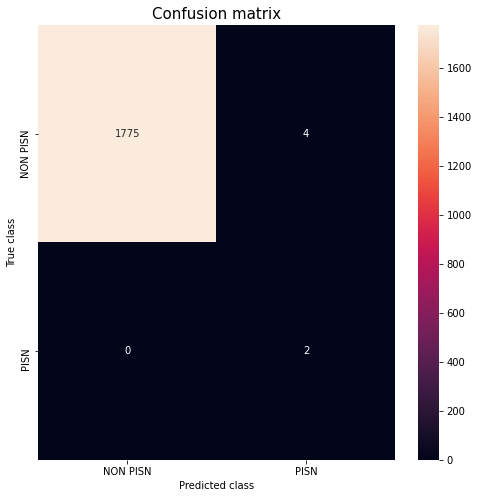

Objects predicted as PISN are really PISN 33.33 % of the time.
PISN are predicted as PISN 100.00 % of the time.


In [40]:
classe_names=[]
for i in range(len(classes)):
    classe_names.append(target_dict.get(classes[i]))

# On calcul la matrice de confusion
conf_matrix = confusion_matrix(y_test, predic_test)

#On affiche la matrice de confusion
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, xticklabels=classe_names, yticklabels=classe_names, annot=True, fmt="d");
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title("Confusion matrix",fontsize=15)

plt.show()

posPISN=len(conf_matrix)-1
print('Objects predicted as PISN are really PISN %.2f %% of the time.'%(100*conf_matrix[posPISN,posPISN]/conf_matrix[:,posPISN].sum()))
print('PISN are predicted as PISN %.2f %% of the time.'%(100*conf_matrix[posPISN,posPISN]/conf_matrix[posPISN,:].sum()))